In [80]:
%matplotlib inline

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from ddsp.core import unit_to_midi, midi_to_unit
from f0_reduced_time_steps import data_generator_iof
from tfrecord_provider import CompleteTFRecordProvider

In [3]:
tfrecord_path = os.path.join('d:/soundofai/complete_data', 'test', 'complete.tfrecord')
data_iterable = iter(CompleteTFRecordProvider(tfrecord_path).get_batch(batch_size=1))

In [5]:
model = tf.keras.models.load_model('checkpoints/f0_clipped_val_loss_0.0020.h5')
data_generator = data_generator_iof(data_iterable)

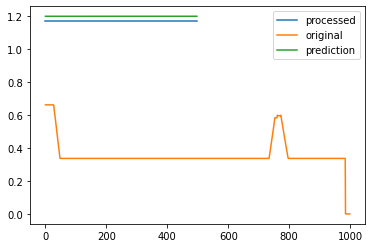

In [416]:
(inputs, outputs), features = next(data_generator)
f0_pred, ld_pred = model.predict(inputs)
f0_pred = np.squeeze(f0_pred)
pred_final = np.zeros((500,))
pred_final[2:] = f0_pred
pred_final[:2] = f0_pred.mean()

plt.plot(np.squeeze(outputs['f0_scaled']), label='processed')
plt.plot(np.squeeze(features['f0_scaled']), label='original')
plt.plot(f0_pred, label='prediction')
plt.legend()
plt.show()

In [417]:
note_number = tf.cast(features['note_number'], tf.float32)
pitch = midi_to_unit(note_number, clip=True, midi_min=0, midi_max=127)
f0_scaled = features['f0_scaled'][:, :500]
f0_scaled_max = midi_to_unit(note_number + 2., clip=True, midi_min=0, midi_max=127)
f0_scaled_min = midi_to_unit(note_number - 2., clip=True, midi_min=0, midi_max=127)
f0_scaled = tf.clip_by_value(f0_scaled, f0_scaled_min, f0_scaled_max)

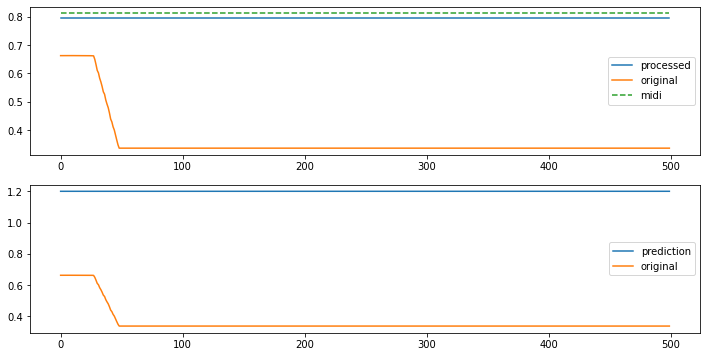

In [418]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(f0_scaled[0], label='processed')
plt.plot(features['f0_scaled'][0, :500], label='original')
plt.plot([np.squeeze(pitch)] * 500, '--', label='midi')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pred_final, label='prediction')
plt.plot(features['f0_scaled'][0, :500], label='original')
plt.legend()

plt.show()